# Agent-based model for News diffusion and misinformation

What I want to do is to create agents that share news, then from there find some interesting insights that could help fake news research

#### The first thing we need to do is to import news article and user classes

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from SimHelper import generate_weighted_sentiment
from random import sample, randint
from tqdm import tqdm_notebook as tqdm
from classes import NewsArticle,User, NewsAgency

1. User attributes:  
  a. unique_id : a non-intelligent number given to the user  
  b. news_spread_chance : a percentage of the user spreading news (can be compared to confidence and censorship)   
  c. preference : the position the user feels about the current subject being discussed  
  d. user_type: the user could be a regular user or a news agency  
  e. articles : a list of articles shared by the user  



2. News agency attributes:  
  a. unique_id : a non-intelligent number given to the user  
  b. news_spread_chance : a percentage of the user spreading news (can be compared to confidence and censorship)   
  c. preference : the position the user feels about the current subject being discussed  
  d. user_type: the user could be a regular user or a news agency  
  e. articles : a list of articles shared by the user  
  f. reliable : indicates how reliable this agency is
        
        
3. News article attributes:  
  a. news_article_id : a non-intelligenct number given to the article  
  b. source_id : the id of the source  
  c. source_preference : the preference of the source  
  d. sentiment : a number from [1,5] or [-5,-1]  
  e. num_shares :  the number of people sharing the article  
  f. fake : 1 if the news is fake, otherwise real

#### Lets try to create a simple news article

In [2]:
x = NewsArticle(1,100,0.8,0.7,4,21,1,50)

In [3]:
x

News Article ID: 1
Source ID: 100
Source Preference: 0.8
Article Preference: 0.7
Sentiment: 4
Number of shares: 21
Fake (True:1, False:0): 1
Tick: 50

In [4]:
u = User(1000,0.5,0.2,'regular',[x])

In [5]:
u

User ID: 1000
News Spread Chance: 0.5
Preference: 0.2
Type: regular

In [6]:
n = NewsAgency(8000,0.9,-0.8,'news_agency',[x],1)

In [7]:
n

User ID: 8000
News Spread Chance: 0.9
Preference: -0.8
Type: news_agency
Reliable:1

#### Now we need to try to create a few users

news_agencies_ratio is a network attribute to add that takes the amount of news agencies in the network  
number_of_users is a network attribute that creates a graph of a certain number of nodes equal to the number of users

In [8]:
from random import random, uniform, choice
from SimHelper import generate_weighted_percentage, generate_bias
from scipy.stats import beta

In [45]:
users = []
regular_users = []
news_users = []

news_agencies_ratio = 0.2
number_of_users = 200

number_of_regualr_users = int(number_of_users*(1-news_agencies_ratio))
number_of_news_users = number_of_users - number_of_regualr_users

print('Number of users:',number_of_users,'\nNumber of regular users:',number_of_regualr_users,'\nNumber of news agencies:',number_of_news_users)

Number of users: 200 
Number of regular users: 160 
Number of news agencies: 40


In [46]:
#create the beta distribution for news agencies to be a beta distribution with alpha=beta=0.3
data_beta = beta.rvs(a=0.3,b=0.3,size=1000)
# data_beta = beta.rvs(a=1,b=5,size=1000)
beta_dist = np.interp(data_beta, (data_beta.min(), data_beta.max()), (-1, 1))
news_reliability = 0.1


for i in tqdm(range(number_of_news_users)):
    unique_id = i
    user_type = 'news_agency' 
    news_spread_chance = 1
    articles = []
    reliable = (generate_weighted_percentage(news_reliability))
    if reliable == 0:
        preference = round(choice([x for x in beta_dist if abs(x)>0.4]),2)
    else:
        preference = round(choice([x for x in beta_dist if abs(x)<0.5]),2)
    news_users.append(NewsAgency(unique_id,news_spread_chance,preference,user_type,articles,reliable))
    users.append(NewsAgency(unique_id,news_spread_chance,preference,user_type,articles,reliable))

for i in tqdm(range(len(news_users),number_of_regualr_users+len(news_users))):
    unique_id = i
    user_type = 'regular'
    news_spread_chance = round(random(),2)
    preference = generate_bias(mu = 0, sigma = 3)    
    articles = []
    regular_users.append(User(unique_id,news_spread_chance,preference,user_type,articles))
    users.append(User(unique_id,news_spread_chance,preference,user_type,articles))
print('Number of users:',number_of_users)
print('Number of regular users:',number_of_regualr_users)
print('Number of news agencies:',number_of_news_users)


Number of users: 200
Number of regular users: 160
Number of news agencies: 40


In [47]:
users[21]

User ID: 21
News Spread Chance: 1
Preference: 0.42
Type: news_agency
Reliable:0

In [48]:
regular_user_count = len([user for user in users if user.user_type == 'regular'])
print('Ratio of regular users=',regular_user_count/number_of_users,' ,and new agencies =', (number_of_users-regular_user_count)/number_of_users)

Ratio of regular users= 0.8  ,and new agencies = 0.2


### Lets try to create a network of the users

In [49]:
import networkx as nx

In [50]:
G = nx.Graph()
G.add_nodes_from(users)

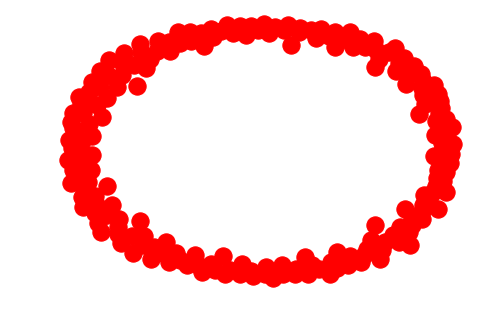

In [51]:
%matplotlib inline
nx.draw(G)

In [52]:
# G = nx.scale_free_graph(100)
# G = G.to_undirected()

In [53]:
color_map = []
for node in list(G.nodes()):
    if node.preference < -0.5:
        color_map.append('red')
    elif node.preference > 0.5:
        color_map.append('blue')
    else:
        color_map.append('grey')

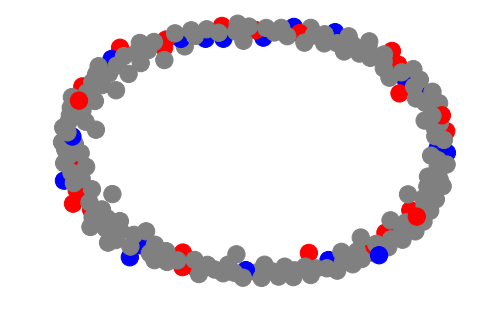

In [54]:
%matplotlib inline
nx.draw(G, node_color=color_map)

#### Add edges by Power law distribution

In [55]:
edge_list = []
for i in range(number_of_users):
    number_of_edges = int((np.random.pareto(a=5)+.1)*30)
    if number_of_edges > number_of_users:
        number_of_edges /= 2
    edge_list.append(int(number_of_edges))

In [56]:
edge_list

[34,
 4,
 18,
 3,
 4,
 4,
 8,
 4,
 4,
 8,
 4,
 4,
 5,
 3,
 6,
 8,
 4,
 8,
 6,
 6,
 13,
 11,
 6,
 5,
 6,
 3,
 3,
 26,
 5,
 5,
 5,
 5,
 17,
 6,
 13,
 25,
 7,
 17,
 7,
 3,
 18,
 3,
 20,
 5,
 3,
 11,
 11,
 4,
 9,
 4,
 6,
 5,
 32,
 7,
 3,
 13,
 4,
 25,
 18,
 3,
 6,
 5,
 4,
 17,
 3,
 5,
 5,
 10,
 7,
 22,
 5,
 4,
 3,
 8,
 8,
 3,
 7,
 10,
 7,
 3,
 13,
 3,
 7,
 9,
 7,
 9,
 3,
 5,
 5,
 4,
 11,
 5,
 5,
 20,
 5,
 7,
 23,
 3,
 16,
 3,
 4,
 26,
 7,
 36,
 5,
 7,
 6,
 4,
 3,
 12,
 10,
 10,
 3,
 4,
 3,
 17,
 8,
 3,
 6,
 7,
 10,
 3,
 5,
 5,
 9,
 8,
 15,
 4,
 7,
 8,
 8,
 6,
 3,
 8,
 12,
 17,
 4,
 19,
 5,
 10,
 3,
 6,
 8,
 17,
 4,
 7,
 8,
 6,
 11,
 3,
 9,
 8,
 10,
 3,
 9,
 6,
 10,
 3,
 6,
 21,
 11,
 16,
 4,
 17,
 23,
 8,
 19,
 11,
 3,
 3,
 19,
 5,
 10,
 3,
 5,
 6,
 4,
 15,
 11,
 4,
 5,
 3,
 10,
 4,
 4,
 9,
 3,
 11,
 6,
 23,
 3,
 28,
 6,
 12,
 22,
 3,
 10,
 8,
 59,
 9]

(array([83., 48., 28.,  7.,  4., 13.,  5.,  5.,  3.,  0.,  1.,  2.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([ 3. ,  5.8,  8.6, 11.4, 14.2, 17. , 19.8, 22.6, 25.4, 28.2, 31. ,
        33.8, 36.6, 39.4, 42.2, 45. , 47.8, 50.6, 53.4, 56.2, 59. ]),
 <a list of 20 Patch objects>)

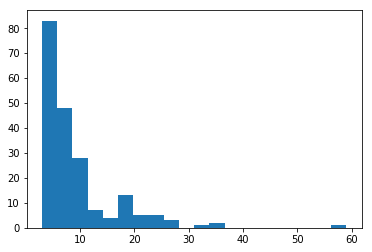

In [57]:
plt.hist(edge_list,bins=20)

In [58]:
from random import sample
for i in range(number_of_users):
    neighbors = sample(users,edge_list[i])
#     print(neighbors)
    for neighbor in neighbors:
      G.add_edge(users[i],neighbor)  

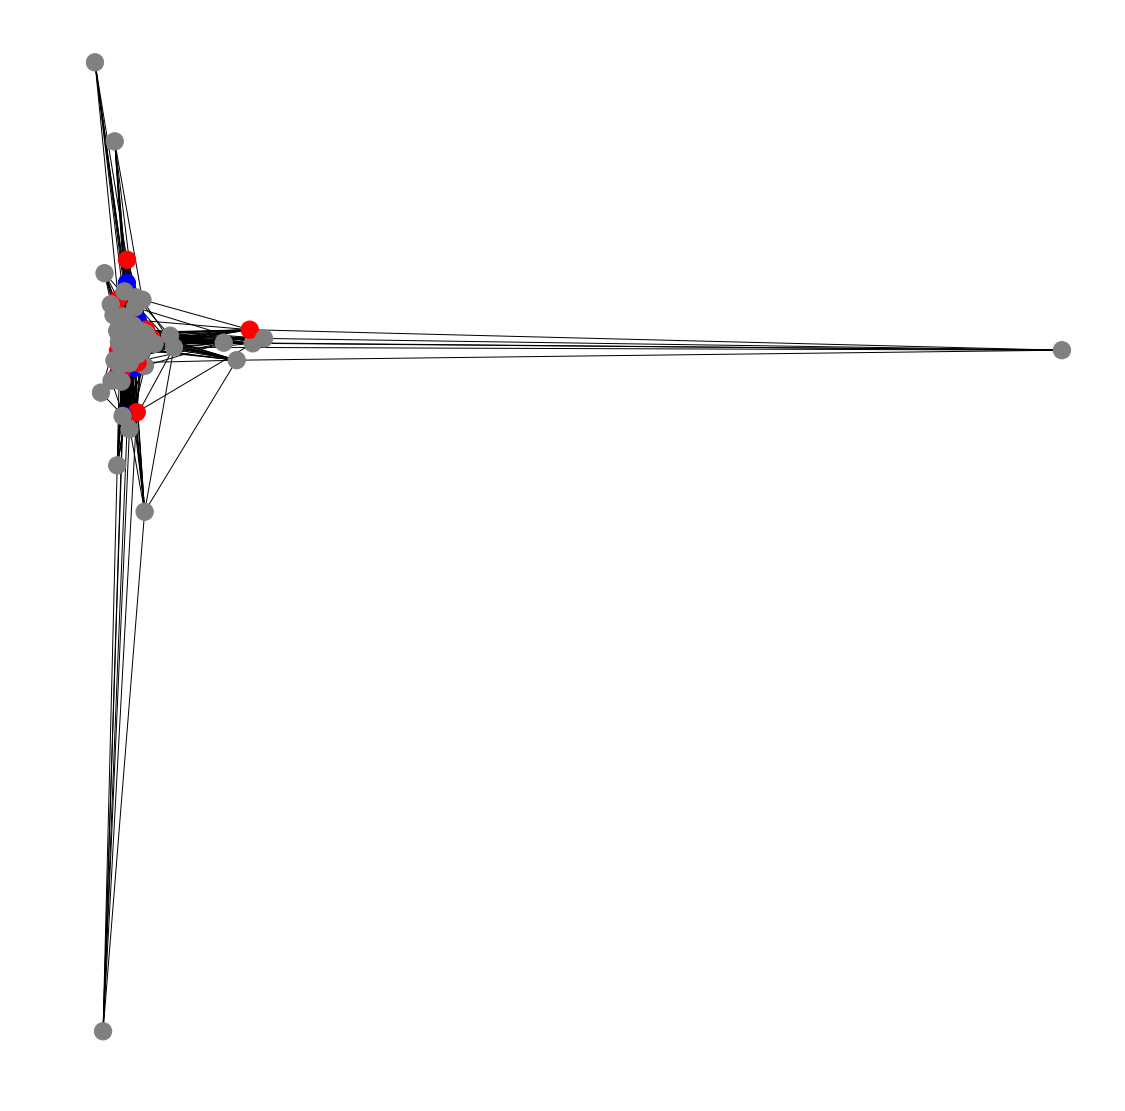

In [59]:
## %matplotlib inline
# nx.draw_spectral(G, node_color=color_map)
pos = nx.spectral_layout(G)
plt.figure(1,figsize=(15,15))
nx.draw(G,pos, node_color=color_map)
plt.show()

In [60]:
import collections

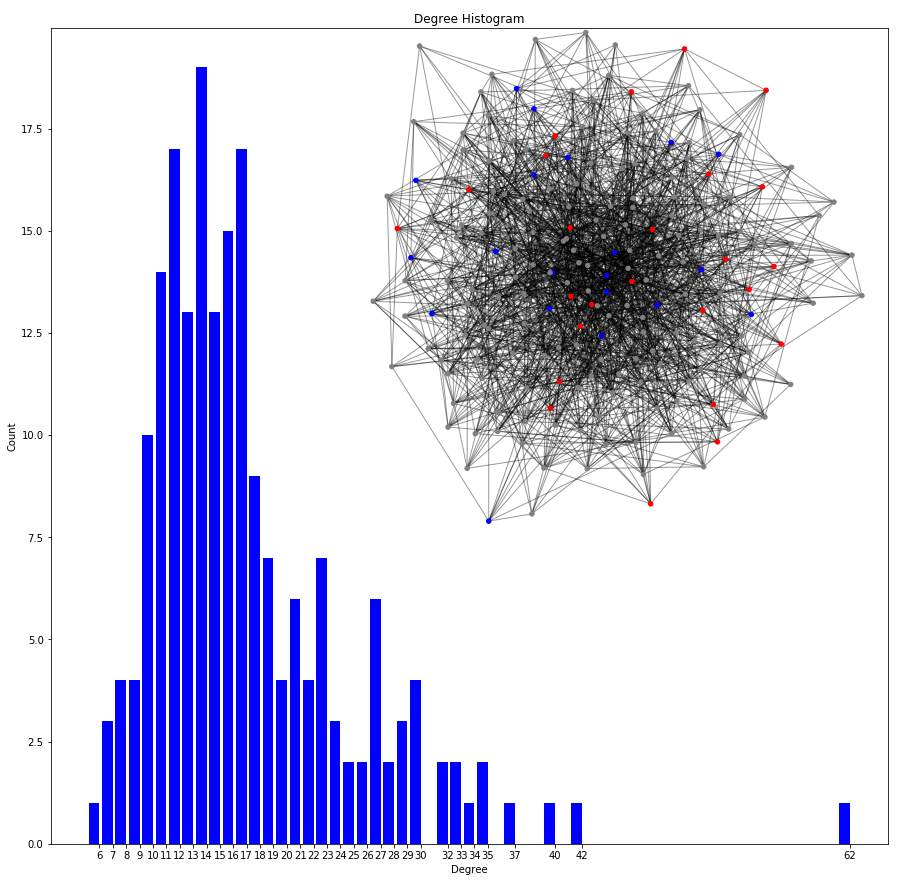

In [61]:
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)  # degree sequence
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())

fig, ax = plt.subplots(figsize=(15,15))
plt.bar(deg, cnt, width=0.80, color="b")
plt.title("Degree Histogram")
plt.ylabel("Count")
plt.xlabel("Degree")
ax.set_xticks([d + 0.4 for d in deg])
ax.set_xticklabels(deg)

# draw graph in inset
plt.axes([0.4, 0.4, 0.5, 0.5])
Gcc = G.subgraph(sorted(nx.connected_components(G), key=len, reverse=True)[0])
pos = nx.spring_layout(G)
plt.axis("off")
nx.draw_networkx_nodes(G, pos, node_size=20, node_color=color_map)
nx.draw_networkx_edges(G, pos, alpha=0.4)
plt.show()

#### Lets spread some news and see how users change their preferences

ticks is another network variable that is used to measure time, it does not mean a specfic time stamp we know at the moment  
fake_news_prob is another network variable that measures how much the percentage of fake news will be generated throughout the network  
For every time step t:  
- Make news events from the news agencies  
- Ask every agent to spread their articles across the network  
- Change the 'regular' user preference and compute overall network preference

In [62]:
def create_news_event (user,sentiment,fake,tick):
    """
    Make a news event
    a. news_article_id
    b. source_id : the id of the source
    c. source_preference : the preference of the source
    d. sentiment : a number from [1,5] or [-5,-1]
    e. num_shares : the number of people sharing the article
    f. fake : 1 if the news is fake, otherwise real
    """
    # assign an id in the format of user id + 1000
    if not user.articles:
        news_id = int(str(user.unique_id)+str(1000))
    else:
        news_id = user.articles[-1].news_article_id +1
#     print(news_id)
    # get source_id and source_preference
    source_id = user.unique_id
    source_preference = user.preference
    #generate a preference randomly distributed around the source preference
    if fake:
        article_preference = round(np.random.normal(loc=source_preference, scale = 0.14),2)
        if np.sign(article_preference) != np.sign(user.preference):
            article_preference *= -1
    else:
        article_preference = round(np.random.normal(loc=source_preference, scale = 0.07),2)
    if article_preference > 1:
        article_preference = 1
    elif article_preference < -1:
        article_preference = -1
    sentiment = sentiment
    num_shares = 1
    fake = fake
    tick = tick
    
    article = NewsArticle(news_id,source_id,source_preference,article_preference,sentiment,num_shares,fake,tick)
    
    user.articles.append(article)

Test the create_news_event function

In [63]:
if u.articles:
    u.articles.clear()
create_news_event(u,generate_weighted_sentiment(),0,3)

u.articles[0]

News Article ID: 10001000
Source ID: 1000
Source Preference: 0.2
Article Preference: 0.18
Sentiment: 2.26
Number of shares: 1
Fake (True:1, False:0): 0
Tick: 3

In [64]:
def get_neighbor_preferences(user):
    """
    Get the average preference of a user's neighbors
    """
    return round(np.mean([o.preference for o in list(G[users[user.unique_id]])]),2)

    # Simpler version
#     temp = []
#     for n in list(G[users[user.unique_id]]):
#         print(abs(user.preference - n.preference))
#         temp.append(n.preference)
#     return round(np.mean(temp),2)

Test get_neighbor_preferences

In [65]:
get_neighbor_preferences(users[1])

0.02

In [66]:
u1= User(1000,0.5,0.2,'regular',[])
u2= User(1001,0.7,-0.2,'regular',[])
u3= User(1002,0.1,-0.6,'regular',[])
u4= User(1003,0.5,0.7,'regular',[])
u5= User(1004,0.3,0.3,'regular',[])

H = nx.Graph()
H.add_nodes_from([u1,u2,u3,u4,u5])

H.add_edge(u1,u4)
H.add_edge(u4,u5)
H.add_edge(u5,u2)
H.add_edge(u2,u3)
H.add_edge(u3,u1)
H.add_edge(u1,u5)

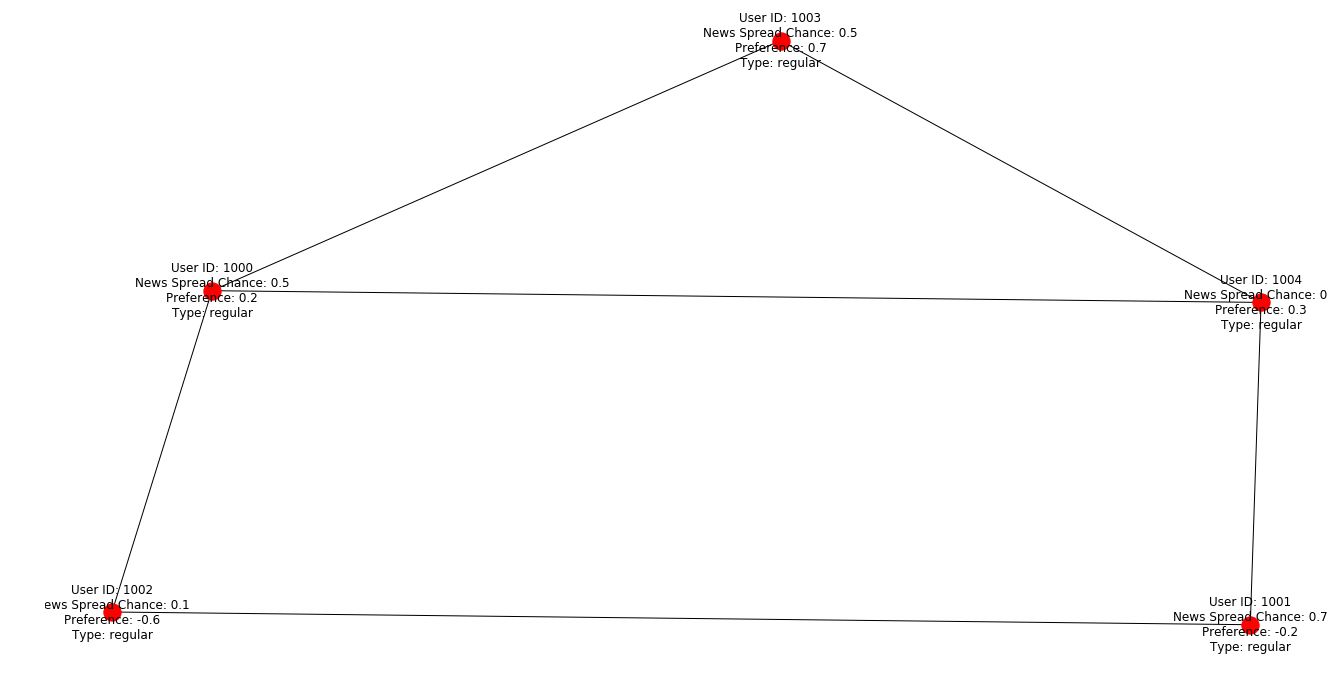

In [67]:
plt.figure(1,figsize=(23,12))
nx.draw_networkx(H)
plt.axis('off')
plt.show()

In [68]:
round(np.mean([o.preference for o in list(H[u5])]),2)

0.23

In [69]:
create_news_event(u1,generate_weighted_sentiment(),0,0)
create_news_event(u1,generate_weighted_sentiment(a=4),1,0)
create_news_event(u1,generate_weighted_sentiment(),0,1)
create_news_event(u2,generate_weighted_sentiment(),0,2)
create_news_event(u4,generate_weighted_sentiment(a=4),0,2)

In [70]:
recommendations = [article for user in list(H[u5]) for article in user.articles if np.sign(u5.preference) == np.sign(article.article_preference)]
recommendations.sort(key=lambda x: (abs(x.sentiment),x.tick,x.num_shares), reverse=True)

In [71]:
recommendations

[News Article ID: 10001000
 Source ID: 1000
 Source Preference: 0.2
 Article Preference: 0.17
 Sentiment: 3.85
 Number of shares: 1
 Fake (True:1, False:0): 0
 Tick: 0, News Article ID: 10001001
 Source ID: 1000
 Source Preference: 0.2
 Article Preference: 0.11
 Sentiment: -3.34
 Number of shares: 1
 Fake (True:1, False:0): 1
 Tick: 0, News Article ID: 10031000
 Source ID: 1003
 Source Preference: 0.7
 Article Preference: 0.83
 Sentiment: 2.67
 Number of shares: 1
 Fake (True:1, False:0): 0
 Tick: 2, News Article ID: 10001002
 Source ID: 1000
 Source Preference: 0.2
 Article Preference: 0.29
 Sentiment: 1.51
 Number of shares: 1
 Fake (True:1, False:0): 0
 Tick: 1]

In [72]:
np.sign(u1.preference) == np.sign(recommendations[0].article_preference) == np.sign(u4.preference)

True

In [142]:
preds = nx.preferential_attachment(H)
# for u, v, p in preds:
#     print('(%d, %d) -> %d' % (u, v, p))

In [143]:
list(preds)

[(User ID: 1000
  News Spread Chance: 0.5
  Preference: 0.2
  Type: regular, User ID: 1001
  News Spread Chance: 0.7
  Preference: -0.2
  Type: regular, 6), (User ID: 1004
  News Spread Chance: 0.3
  Preference: 0.3
  Type: regular, User ID: 1002
  News Spread Chance: 0.1
  Preference: -0.6
  Type: regular, 6), (User ID: 1001
  News Spread Chance: 0.7
  Preference: -0.2
  Type: regular, User ID: 1003
  News Spread Chance: 0.5
  Preference: 0.7
  Type: regular, 4), (User ID: 1002
  News Spread Chance: 0.1
  Preference: -0.6
  Type: regular, User ID: 1003
  News Spread Chance: 0.5
  Preference: 0.7
  Type: regular, 4)]

In [130]:
from networkx.algorithms.community.kernighan_lin import kernighan_lin_bisection as klb
from networkx.algorithms.community.centrality import girvan_newman as gn

In [121]:
communities = klb(G)

In [129]:
communities[1]

{User ID: 0
 News Spread Chance: 1
 Preference: 0.6
 Type: news_agency
 Reliable:0, User ID: 101
 News Spread Chance: 0.25
 Preference: 0.04
 Type: regular, User ID: 102
 News Spread Chance: 0.27
 Preference: 0.13
 Type: regular, User ID: 112
 News Spread Chance: 0.68
 Preference: -0.22
 Type: regular, User ID: 113
 News Spread Chance: 0.57
 Preference: 0.45
 Type: regular, User ID: 114
 News Spread Chance: 0.67
 Preference: -0.42
 Type: regular, User ID: 115
 News Spread Chance: 0.0
 Preference: 0.4
 Type: regular, User ID: 116
 News Spread Chance: 0.73
 Preference: -0.09
 Type: regular, User ID: 117
 News Spread Chance: 0.82
 Preference: 0.26
 Type: regular, User ID: 119
 News Spread Chance: 0.74
 Preference: -0.26
 Type: regular, User ID: 12
 News Spread Chance: 1
 Preference: -0.89
 Type: news_agency
 Reliable:0, User ID: 120
 News Spread Chance: 0.14
 Preference: 0.27
 Type: regular, User ID: 122
 News Spread Chance: 0.62
 Preference: -0.36
 Type: regular, User ID: 123
 News Sprea

In [132]:
comp = gn(G)

In [133]:
tuple(sorted(c) for c in next(comp))

TypeError: '<' not supported between instances of 'User' and 'NewsAgency'

In [73]:
def get_recommendations(user,tick):
    """
    Pick what the user will see on their feed according to a platform strategy
    
    Strategy 1: See the latest news from your neighbors
    Strategy 2: See the most popular news
    Strategy 3: See the most important news in your circle
    Strategy 4: See a random selected news as a benchmark
    Strategy 5: Weighted approach
    Strategy 6: Most shocking news
    """
    recommendations = [article for neighbor in list(G[users[user.unique_id]]) for article in neighbor.articles if article.tick > tick -5]
    recommendations = [article for article in recommendations if np.sign(user.preference) == np.sign(article.article_preference)]
    recommendations.sort(key=lambda x: (x.tick,abs(x.sentiment)), reverse=True)
    try:
        return recommendations[:3]
    except:
        return recommendations

In [84]:
def spread_news(user,tick):
    """
    A user will share to their neighbors based on preference, sentiment, and number of shares
    
    In terms of preference, there are a few measures to find:
    1- individual preferences: user preference and neighbor preference
    2- community preference : mean of preference of neighbors of the neighbor
    3- 
    """
    if not user.articles:
        return
    
    community_opinion = get_neighbor_preferences(user)
    recommendations = get_recommendations(user,tick)
    
    for rec in recommendations:
        # person likes to share
        if generate_weighted_percentage(user.news_spread_chance):
            #person is not silenced
            if np.sign(community_opinion) == np.sign(user.preference) == np.sign(rec.article_preference):
                user.articles.append(rec)
                rec.num_shares += 1
                preference_shift = 0.01
#                 print('before',users[user.unique_id].preference)
                users[user.unique_id].preference = round(users[user.unique_id].preference,2)
                if (np.sign(user.preference) > 0):
                    if users[user.unique_id].preference > rec.article_preference:
                        users[user.unique_id].preference -= preference_shift
                        print(user.unique_id,users[user.unique_id].preference)
                    elif users[user.unique_id].preference < rec.article_preference:
                        users[user.unique_id].preference += preference_shift
                        print(user.unique_id,users[user.unique_id].preference)
                elif (np.sign(user.preference) < 0):
                    if users[user.unique_id].preference > rec.article_preference:
                        users[user.unique_id].preference -= preference_shift
                        print(user.unique_id,users[user.unique_id].preference)
                    elif users[user.unique_id].preference < rec.article_preference:
                        users[user.unique_id].preference += preference_shift
                        print(user.unique_id,users[user.unique_id].preference)
                if users[user.unique_id].preference > 1:
                    users[user.unique_id].preference = 1
                elif users[user.unique_id].preference < -1:
                    users[user.unique_id].preference = -1

In [75]:
def get_regular_user_preferences():
    """
    return the mean and std dev of the user preference
    """
#     preferences = []
#     for node in regular_users:
#         preferences.append(node.preference)

    preferences = []
    for node in users:
        preferences.append(node.preference)

    print('mean = ',round(np.mean(preferences),2),'standard dev = ',round(np.std(preferences),2))
    plt.hist(preferences)

mean =  -0.0 standard dev =  0.44


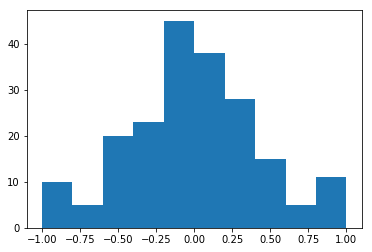

In [76]:
get_regular_user_preferences()

(array([24., 16., 20., 11., 16., 15., 17., 12., 20.,  9.]),
 array([0.   , 0.099, 0.198, 0.297, 0.396, 0.495, 0.594, 0.693, 0.792,
        0.891, 0.99 ]),
 <a list of 10 Patch objects>)

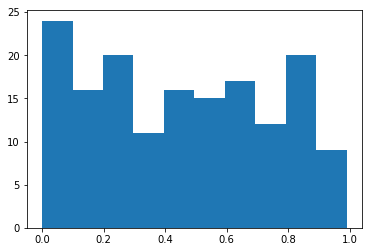

In [77]:
sharing = [x.news_spread_chance for x in users if x.user_type == 'regular']
plt.hist(sharing)

(array([10.,  5., 20., 23., 45., 38., 28., 15.,  5., 11.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <a list of 10 Patch objects>)

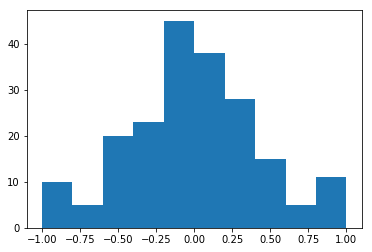

In [78]:
preferences = []
for node in users:
    preferences.append(node.preference)

plt.hist(preferences)

(array([10.,  3.,  7.,  1.,  1.,  0.,  0.,  5.,  2., 11.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <a list of 10 Patch objects>)

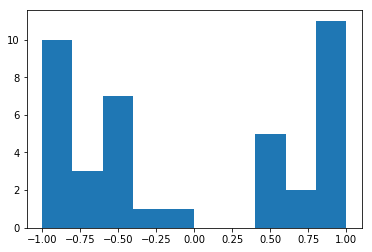

In [79]:
preferences = []
for node in news_users:
    preferences.append(node.preference)

plt.hist(preferences)

In [80]:
def clear_all_news():
    [user.articles.clear() for user in users]

tick number:  0
mean =  0.01 standard dev =  0.29
21 0.76
21 0.77
10 0.82
38 -0.86
39 -0.92
39 -0.91
36 0.72
36 0.71
35 -0.72
35 -0.73
4 0.97
9 -0.84
9 -0.83
28 -0.8200000000000001
28 -0.8099999999999999
28 -0.8200000000000001
11 0.77
11 0.76
13 -0.61
10 0.8099999999999999
29 -0.62
29 -0.61
29 -0.62
15 0.61
15 0.6
15 0.61
21 0.78
21 0.77
21 0.78
38 -0.87
38 -0.86
38 -0.87
36 0.72
36 0.71
36 0.7
14 0.84
14 0.85
39 -0.92
39 -0.93
39 -0.9400000000000001
12 -0.9
12 -0.89
25 -0.76
25 -0.77
25 -0.78
28 -0.83
28 -0.82
28 -0.8099999999999999
11 0.75
11 0.76
11 0.75
39 -0.95
39 -0.96
39 -0.97
14 0.84
14 0.85
28 -0.8200000000000001
28 -0.8099999999999999
4 0.98
4 0.99
4 0.98
11 0.76
11 0.75
11 0.76
10 0.8200000000000001
10 0.8099999999999999
21 0.77
21 0.78
21 0.79
12 -0.9
12 -0.91
12 -0.9
15 0.62
15 0.63
15 0.62
13 -0.6
13 -0.59
13 -0.58
31 -0.95
31 -0.96
31 -0.95
12 -0.89
12 -0.9
12 -0.91
31 -0.96
31 -0.95
31 -0.96
14 0.86
14 0.87
14 0.86
39 -0.98
29 -0.61
29 -0.6
29 -0.59
9 -0.82
9 -0.8099999

31 -0.92
31 -0.91
21 0.71
21 0.7
21 0.69
29 -0.64
29 -0.65
29 -0.66
11 0.7
11 0.69
11 0.6799999999999999
35 -0.66
35 -0.67
35 -0.68
15 0.65
15 0.64
15 0.63
21 0.7
21 0.69
21 0.6799999999999999
29 -0.67
29 -0.68
29 -0.6900000000000001
14 0.89
14 0.9
31 -0.92
31 -0.91
9 -0.73
9 -0.74
9 -0.73
4 0.98
4 0.97
4 0.96
39 -0.9400000000000001
39 -0.9299999999999999
25 -0.86
25 -0.85
25 -0.86
15 0.64
15 0.63
15 0.62
10 0.83
10 0.82
13 -0.51
13 -0.52
13 -0.53
14 0.89
12 -0.88
12 -0.87
12 -0.86
tick number:  80
mean =  0.01 standard dev =  0.29
12 -0.87
12 -0.86
12 -0.85
15 0.63
15 0.62
15 0.61
13 -0.54
13 -0.55
13 -0.56
38 -0.87
38 -0.88
38 -0.89
28 -0.89
28 -0.88
28 -0.87
35 -0.67
35 -0.68
35 -0.67
12 -0.84
12 -0.85
12 -0.84
39 -0.92
39 -0.91
39 -0.92
9 -0.74
9 -0.75
9 -0.74
21 0.6900000000000001
21 0.7
21 0.69
11 0.6900000000000001
11 0.6799999999999999
36 0.67
36 0.68
29 -0.6799999999999999
29 -0.6900000000000001
29 -0.6799999999999999
15 0.6
15 0.61
15 0.62
4 0.97
4 0.96
4 0.97
35 -0.68
35 -0.

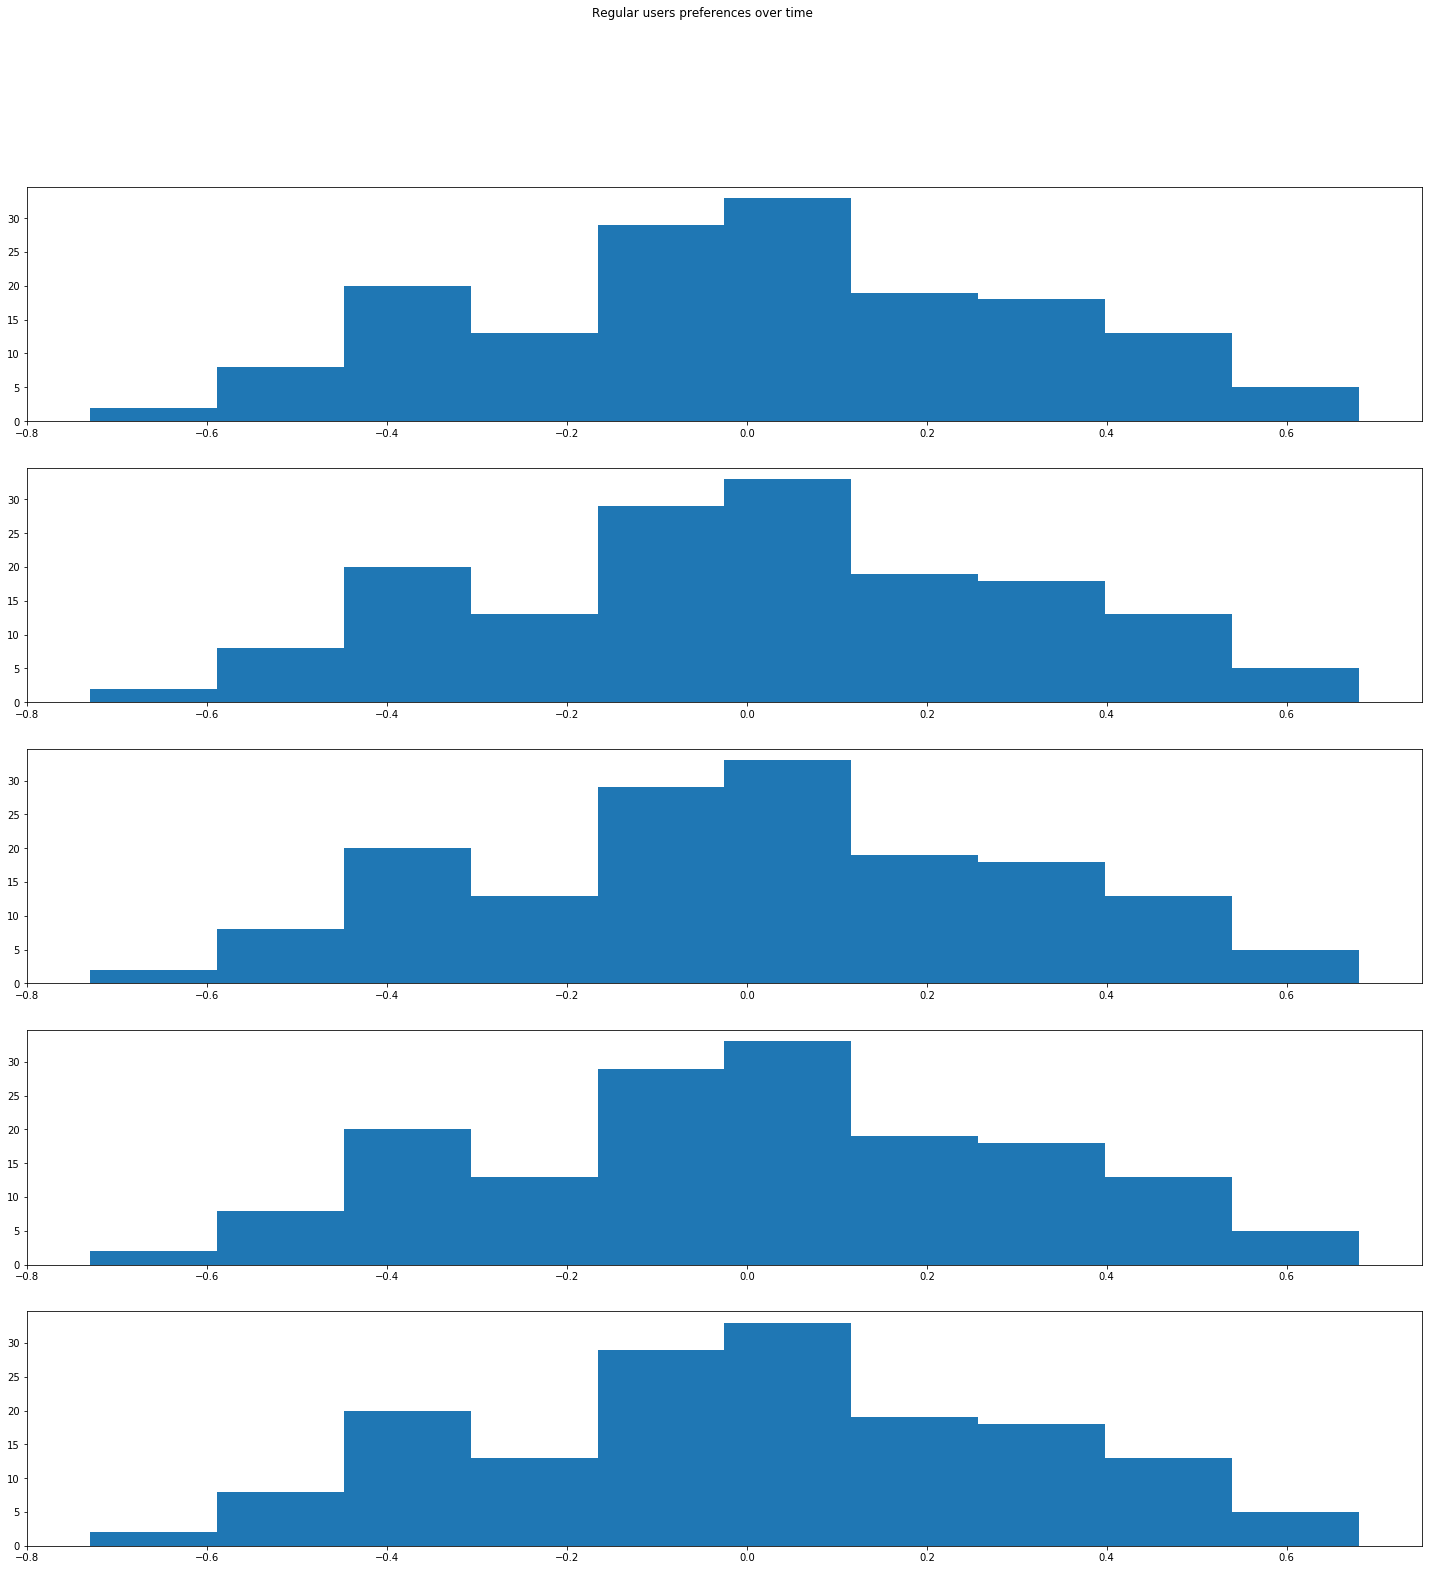

In [86]:
ticks = 100
pause = 20
fake_news_prob = 0.9

clear_all_news()

fig,axs = plt.subplots(int(ticks/pause),figsize=(25,25))
fig.suptitle('Regular users preferences over time')
plots = 0
for tick in range(ticks):
    if tick % pause == 0:
        print('tick number: ',tick)
#         get_regular_user_preferences()
        preferences = [user.preference for user in users if user.user_type == 'regular']
        print('mean = ',round(np.mean(preferences),2),'standard dev = ',round(np.std(preferences),2))
        axs[plots].hist(preferences)
        plots += 1
        
    sampled_news_agencies = sample(news_users,randint(1,len(news_users)-1))
    for n in sampled_news_agencies:
        if n.reliable == 0:
            if generate_weighted_percentage(fake_news_prob):
                #generate fake news
                sentiment = generate_weighted_sentiment(a=4)
                fake = 1
        else:
            #generate real news
            sentiment = generate_weighted_sentiment()
            fake = 0
        create_news_event(n,sentiment,fake,tick)
        spread_news(n,tick)
    sampled_regular_users = sample(regular_users,randint(1,len(regular_users)-1))
    for u in sampled_regular_users:
        spread_news(u,tick)
print('mean = ',round(np.mean(preferences),2),'standard dev = ',round(np.std(preferences),2))

(array([870., 543., 242.,  67.,   5.,   0.,  70., 282., 533., 747.]),
 array([-5., -4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.,  5.]),
 <a list of 10 Patch objects>)

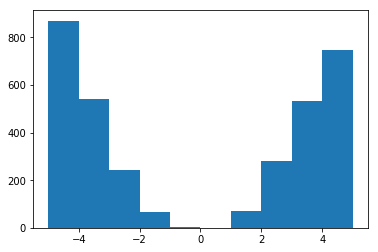

In [52]:
#histogram of all articles being shared
articles = []
for node in list(G.nodes):
    for article in node.articles:
        articles.append(article.sentiment) 

plt.hist(articles)

(array([473., 342., 152.,  51.,   3.,   0.,  56., 181., 335., 453.]),
 array([-5., -4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.,  5.]),
 <a list of 10 Patch objects>)

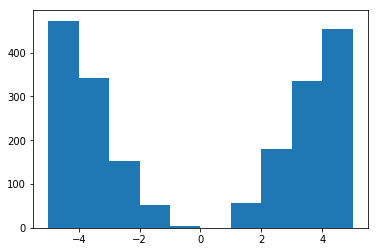

In [53]:
#histogram of UNIQUE articles being shared
articles_unique = []
articles_set = set()
for node in list(G.nodes):
    for article in node.articles:
        if article not in articles_set:
            articles_set.add(article)
            articles_unique.append(article.sentiment) 

plt.hist(articles_unique)

In [47]:
len(articles_unique)

20538

In [48]:
len(articles)

39136

(array([15.,  4., 17., 30., 29., 38., 23., 17.,  7., 20.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <a list of 10 Patch objects>)

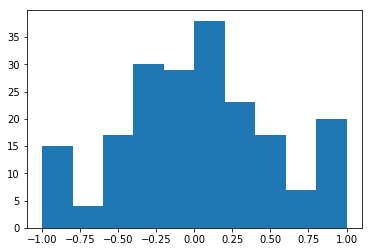

In [49]:
preferences = []
for node in users:
    preferences.append(node.preference)

plt.hist(preferences)